In [1]:
import numpy as np
import pandas as pd
import math
from random import sample
import matplotlib.pyplot as plt

import imgaug.augmenters as iaa
import imgaug
from skimage import io

In [2]:
#data_dir = '/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification'  
data_dir = 'data'
image_width = 600
image_height = 600
channels = 3

In [3]:
df_train_full = pd.read_csv(data_dir+'/train.csv', dtype={'Id': str})
df_extra = pd.read_csv(data_dir+'/data.csv', dtype={'Id': str})
df_train_full = pd.concat([df_train_full, df_extra], ignore_index = True)
df_train_full['filename'] = data_dir+'/images/' + df_train_full['Id'] + '.jpg'
df_train_full.head()

,Id,label,filename
0,0560,glass,data/images/0560.jpg
1,4675,cup,data/images/4675.jpg
2,0875,glass,data/images/0875.jpg
3,4436,spoon,data/images/4436.jpg
4,8265,plate,data/images/8265.jpg


In [4]:
df_train_full.label.unique()

array(['glass', 'cup', 'spoon', 'plate', 'knife', 'fork'], dtype=object)

In [5]:
df_train_full.label.value_counts()

plate    1698
cup      1625
spoon    1512
knife    1357
glass    1020
fork      776
Name: label, dtype: int64

In [6]:
df_glass = df_train_full.query('label == "glass"').copy()
df_glass.reset_index(drop=True, inplace = True)
df_glass

,Id,label,filename
0,0560,glass,data/images/0560.jpg
1,0875,glass,data/images/0875.jpg
2,6477,glass,data/images/6477.jpg
3,2031,glass,data/images/2031.jpg
4,3929,glass,data/images/3929.jpg
...,...,...,...
1015,eu.c9e0e8c3-e295-4166-9aa7-424b33bf7365,glass,data/images/eu.c9e0e8c3-e295-4166-9aa7-424b33b...
1016,eu.63ef6449-c963-4e68-be0d-4a9c0009c43c,glass,data/images/eu.63ef6449-c963-4e68-be0d-4a9c000...
1017,eu.57e2dc09-2666-461a-96aa-d70d9ae4b4c5,glass,data/images/eu.57e2dc09-2666-461a-96aa-d70d9ae...
1018,eu.50858fcc-27f4-41ce-9a9c-900a385102f1,glass,data/images/eu.50858fcc-27f4-41ce-9a9c-900a385...


In [7]:
glasses = []
for filename in df_glass.filename:
    image = io.imread(filename)
    glasses.append(image)


In [8]:
train_aug = iaa.Sequential(
    [
        iaa.Resize({"height": image_height, "width": image_width}, interpolation=imgaug.ALL),
        iaa.Fliplr(1),
        iaa.Flipud(1), # vertically flip 20% of all images
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        #iaa.Sometimes(0.3,iaa.Multiply((0.8, 1.2), per_channel=0.2)),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        #iaa.Sometimes(0.3, iaa.Cutout(nb_iterations = (2, 5), size = (.1, .2))),
        iaa.Sometimes(0.5, iaa.GammaContrast((0.5, 2.0), per_channel=True)),
        iaa.Sometimes(0.5, iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30))),
        iaa.Sometimes(0.7, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        #iaa.Sometimes(0.4, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        #iaa.Sometimes(0.4, iaa.imgcorruptlike.GaussianNoise(severity=(1,4))),
        #iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.3, iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)),
        #iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(0, 0.5))),
        #iaa.Sometimes(0.1, iaa.Cartoon(blur_ksize=3, segmentation_size=1.0, saturation=2.0, edge_prevalence=1.0))
    ],
    random_order=True,
    name = "train_aug"
)

In [9]:
train_aug1 = iaa.Sequential(
    [
        iaa.Resize({"height": image_height, "width": image_width}, interpolation=imgaug.ALL),
        iaa.Fliplr(1),
        #iaa.Flipud(1), # vertically flip 20% of all images
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        #iaa.Sometimes(0.3,iaa.Multiply((0.8, 1.2), per_channel=0.2)),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        #iaa.Sometimes(0.3, iaa.Cutout(nb_iterations = (2, 5), size = (.1, .2))),
        iaa.Sometimes(0.5, iaa.GammaContrast((0.5, 1.0), per_channel=True)),
        iaa.Sometimes(0.5, iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 30))),
        iaa.Sometimes(0.7, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        #iaa.Sometimes(0.4, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        iaa.imgcorruptlike.GaussianNoise(severity=(1,4)),
        #iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.3, iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)),
        #iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(0, 0.5))),
        #iaa.Sometimes(0.1, iaa.Cartoon(blur_ksize=3, segmentation_size=1.0, saturation=2.0, edge_prevalence=1.0))
    ],
    random_order=True,
    name = "train_aug1"
)

In [10]:
train_aug2 = iaa.Sequential(
    [
        iaa.Resize({"height": image_height, "width": image_width}, interpolation=imgaug.ALL),
        #iaa.Fliplr(1),
        iaa.Flipud(1), # vertically flip 20% of all images
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        #iaa.Sometimes(0.3,iaa.Multiply((0.8, 1.2), per_channel=0.2)),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        #iaa.Sometimes(0.3, iaa.Cutout(nb_iterations = (2, 5), size = (.1, .2))),
        #iaa.Sometimes(0.5, iaa.GammaContrast((0.5, 2.0), per_channel=True)),
        iaa.Sometimes(0.5, iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.0), add=(-30, 30))),
        iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50)))),
        #iaa.Sometimes(0.4, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        #iaa.Sometimes(0.4, iaa.imgcorruptlike.GaussianNoise(severity=(1,4))),
        #iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.3, iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)),
        #iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(0, 0.5))),
        #iaa.Sometimes(0.1, iaa.Cartoon(blur_ksize=3, segmentation_size=1.0, saturation=2.0, edge_prevalence=1.0))
    ],
    random_order=True,
    name = "train_aug2"
)

In [11]:
train_aug3 = iaa.Sequential(
    [
        iaa.Resize({"height": image_height, "width": image_width}, interpolation=imgaug.ALL),
        iaa.Fliplr(.6),
        iaa.Flipud(.6), # vertically flip 20% of all images
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        #iaa.Sometimes(0.3,iaa.Multiply((0.8, 1.2), per_channel=0.2)),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Cutout(nb_iterations = (2, 5), size = (.07, .2)),
        iaa.Sometimes(0.5, iaa.GammaContrast((0.5, 1.0), per_channel=True)),
        iaa.Sometimes(0.5, iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.0), add=(-30, 30))),
        iaa.Sometimes(0.7, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        #iaa.Sometimes(0.4, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        iaa.Sometimes(0.4, iaa.imgcorruptlike.GaussianNoise(severity=(1,4))),
        #iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.3, iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)),
        #iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(0, 0.5))),
        #iaa.Sometimes(0.1, iaa.Cartoon(blur_ksize=3, segmentation_size=1.0, saturation=2.0, edge_prevalence=1.0))
    ],
    random_order=True,
    name = "train_aug3"
)

In [12]:
train_aug4 = iaa.Sequential(
    [
        iaa.Resize({"height": image_height, "width": image_width}, interpolation=imgaug.ALL),
        iaa.Fliplr(.6),
        iaa.Flipud(.6), # vertically flip 20% of all images
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        #iaa.Sometimes(0.3,iaa.Multiply((0.8, 1.2), per_channel=0.2)),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Cutout(nb_iterations = (2, 5), size = (.1, .2))),
        iaa.Sometimes(0.5, iaa.GammaContrast((0.5, 1.0), per_channel=True)),
        iaa.Sometimes(0.5, iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.0), add=(-30, 30))),
        iaa.Sometimes(0.7, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        #iaa.Sometimes(0.4, iaa.WithHueAndSaturation(iaa.WithChannels(0, iaa.Add((0, 50))))),
        iaa.imgcorruptlike.GaussianNoise(severity=(1,4)),
        #iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.3, iaa.AllChannelsCLAHE(clip_limit=(1, 10), per_channel=True)),
        #iaa.Sometimes(0.1, iaa.GaussianBlur(sigma=(0, 0.5))),
        #iaa.Sometimes(0.1, iaa.Cartoon(blur_ksize=3, segmentation_size=1.0, saturation=2.0, edge_prevalence=1.0))
    ],
    random_order=True,
    name = "train_aug4"
)

In [13]:
glasses_aug = train_aug(images = sample(glasses, 680))
#glasses_aug += train_aug1(images = glasses)
#glasses_aug += train_aug2(images = glasses)
#glasses_aug += train_aug3(images = glasses)
#glasses_aug += train_aug4(images = glasses)

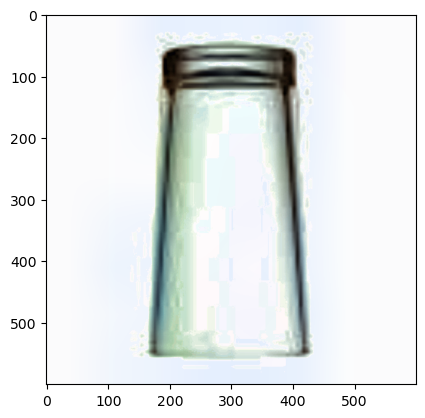

In [14]:
image = glasses_aug[361]
plt.imshow(image)

In [15]:
np.asarray(glasses_aug).shape

(680, 600, 600, 3)

In [16]:
len(glasses_aug)

680

In [17]:
df_glasses_aug = pd.DataFrame(columns = ['Id', 'label'], dtype = str)
for i in range(len(glasses_aug)):
    file_name = 'glass_aug_'+str(i)
    io.imsave(data_dir+'/images/'+file_name+'.jpg', glasses_aug[i])
    df_glasses_aug.loc[len(df_glasses_aug)] = ['glass_aug_'+str(i), 'glass']
    
df_glasses_aug

,Id,label
0,glass_aug_0,glass
1,glass_aug_1,glass
2,glass_aug_2,glass
3,glass_aug_3,glass
4,glass_aug_4,glass
...,...,...
675,glass_aug_675,glass
676,glass_aug_676,glass
677,glass_aug_677,glass
678,glass_aug_678,glass


In [18]:
df_glasses_aug.to_csv(data_dir+'/glasses_aug.csv', index = False)

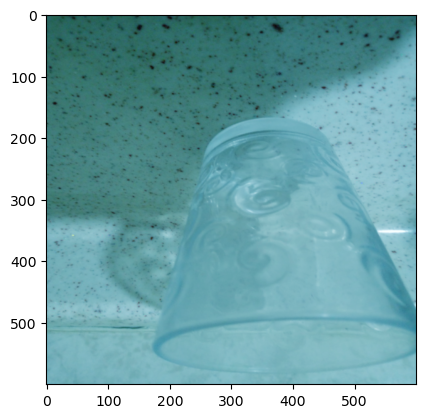

In [19]:
image = glasses_aug[500]
plt.imshow(image)